# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

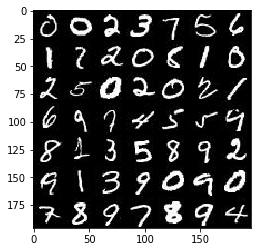

In [2]:
show_n_images = 57

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

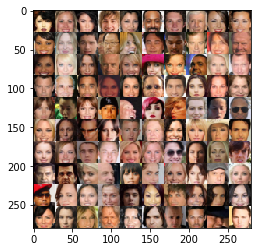

In [3]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return real_input,z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
 
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
           
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flattened by reshaping the tensor
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train ):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshaped tensor to build the convolutional neural network
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512 
        
        x2 = tf.layers.conv2d_transpose(relu1, 256,5 , strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x256 
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x256 
        
        out = tf.tanh(logits)
        
        return out
    
    
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]


    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, output_dim)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1

                #Rescaling images
                batch_images *= 2.0

                # Random Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Optimizing
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 2nd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 3rd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)

    return None
              

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch# 10... Discriminator Loss: 0.6968... Generator Loss: 1.0140
Epoch 1/2 Batch# 20... Discriminator Loss: 2.2966... Generator Loss: 0.1935
Epoch 1/2 Batch# 30... Discriminator Loss: 2.6346... Generator Loss: 0.1738
Epoch 1/2 Batch# 40... Discriminator Loss: 2.5474... Generator Loss: 0.1861
Epoch 1/2 Batch# 50... Discriminator Loss: 2.2790... Generator Loss: 0.3413
Epoch 1/2 Batch# 60... Discriminator Loss: 2.0882... Generator Loss: 0.2112
Epoch 1/2 Batch# 70... Discriminator Loss: 1.8943... Generator Loss: 0.2896
Epoch 1/2 Batch# 80... Discriminator Loss: 1.9096... Generator Loss: 0.2477
Epoch 1/2 Batch# 90... Discriminator Loss: 1.7679... Generator Loss: 0.3098
Epoch 1/2 Batch# 100... Discriminator Loss: 1.6842... Generator Loss: 0.3307


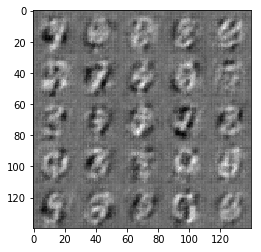

Epoch 1/2 Batch# 110... Discriminator Loss: 1.8869... Generator Loss: 0.2347
Epoch 1/2 Batch# 120... Discriminator Loss: 1.7388... Generator Loss: 0.2951
Epoch 1/2 Batch# 130... Discriminator Loss: 1.5521... Generator Loss: 0.5419
Epoch 1/2 Batch# 140... Discriminator Loss: 1.4899... Generator Loss: 0.5655
Epoch 1/2 Batch# 150... Discriminator Loss: 1.5610... Generator Loss: 0.9373
Epoch 1/2 Batch# 160... Discriminator Loss: 1.4992... Generator Loss: 0.6164
Epoch 1/2 Batch# 170... Discriminator Loss: 1.5917... Generator Loss: 0.7436
Epoch 1/2 Batch# 180... Discriminator Loss: 1.5370... Generator Loss: 0.3578
Epoch 1/2 Batch# 190... Discriminator Loss: 1.5472... Generator Loss: 0.7736
Epoch 1/2 Batch# 200... Discriminator Loss: 1.5578... Generator Loss: 0.8902


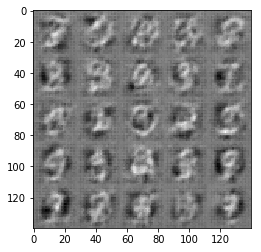

Epoch 1/2 Batch# 210... Discriminator Loss: 1.6126... Generator Loss: 0.3381
Epoch 1/2 Batch# 220... Discriminator Loss: 1.5914... Generator Loss: 0.4231
Epoch 1/2 Batch# 230... Discriminator Loss: 1.8551... Generator Loss: 0.2370
Epoch 1/2 Batch# 240... Discriminator Loss: 1.4811... Generator Loss: 0.6671
Epoch 1/2 Batch# 250... Discriminator Loss: 1.6796... Generator Loss: 0.7546
Epoch 1/2 Batch# 260... Discriminator Loss: 1.5806... Generator Loss: 0.6737
Epoch 1/2 Batch# 270... Discriminator Loss: 1.7393... Generator Loss: 0.8729
Epoch 1/2 Batch# 280... Discriminator Loss: 2.0084... Generator Loss: 0.1891
Epoch 1/2 Batch# 290... Discriminator Loss: 1.7024... Generator Loss: 0.7319
Epoch 1/2 Batch# 300... Discriminator Loss: 1.7294... Generator Loss: 0.3139


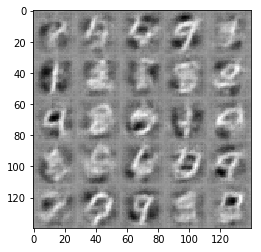

Epoch 1/2 Batch# 310... Discriminator Loss: 1.6629... Generator Loss: 0.3067
Epoch 1/2 Batch# 320... Discriminator Loss: 1.6383... Generator Loss: 0.3617
Epoch 1/2 Batch# 330... Discriminator Loss: 1.7229... Generator Loss: 0.5492
Epoch 1/2 Batch# 340... Discriminator Loss: 1.7857... Generator Loss: 0.2731
Epoch 1/2 Batch# 350... Discriminator Loss: 1.5305... Generator Loss: 0.4976
Epoch 1/2 Batch# 360... Discriminator Loss: 1.9636... Generator Loss: 0.2029
Epoch 1/2 Batch# 370... Discriminator Loss: 1.7266... Generator Loss: 0.5440
Epoch 1/2 Batch# 380... Discriminator Loss: 1.7867... Generator Loss: 0.6950
Epoch 1/2 Batch# 390... Discriminator Loss: 1.9077... Generator Loss: 0.2172
Epoch 1/2 Batch# 400... Discriminator Loss: 1.8277... Generator Loss: 0.2500


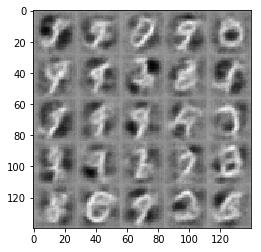

Epoch 1/2 Batch# 410... Discriminator Loss: 1.8485... Generator Loss: 0.2474
Epoch 1/2 Batch# 420... Discriminator Loss: 1.6812... Generator Loss: 0.4382
Epoch 1/2 Batch# 430... Discriminator Loss: 1.7230... Generator Loss: 0.3287
Epoch 1/2 Batch# 440... Discriminator Loss: 1.6511... Generator Loss: 0.4798
Epoch 1/2 Batch# 450... Discriminator Loss: 1.7643... Generator Loss: 0.2848
Epoch 1/2 Batch# 460... Discriminator Loss: 1.7038... Generator Loss: 0.3402
Epoch 2/2 Batch# 10... Discriminator Loss: 1.7417... Generator Loss: 0.3359
Epoch 2/2 Batch# 20... Discriminator Loss: 1.5716... Generator Loss: 0.8966
Epoch 2/2 Batch# 30... Discriminator Loss: 1.5803... Generator Loss: 0.6692
Epoch 2/2 Batch# 40... Discriminator Loss: 1.5859... Generator Loss: 0.4378
Epoch 2/2 Batch# 50... Discriminator Loss: 1.9603... Generator Loss: 0.2038
Epoch 2/2 Batch# 60... Discriminator Loss: 1.7344... Generator Loss: 0.2718
Epoch 2/2 Batch# 70... Discriminator Loss: 1.6136... Generator Loss: 0.5482
Epoch 

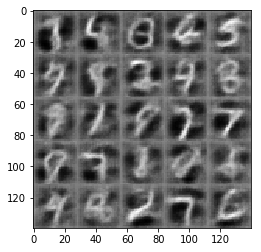

Epoch 2/2 Batch# 110... Discriminator Loss: 1.8904... Generator Loss: 0.2182
Epoch 2/2 Batch# 120... Discriminator Loss: 1.6860... Generator Loss: 0.3083
Epoch 2/2 Batch# 130... Discriminator Loss: 1.6951... Generator Loss: 0.3057
Epoch 2/2 Batch# 140... Discriminator Loss: 1.4795... Generator Loss: 0.8914
Epoch 2/2 Batch# 150... Discriminator Loss: 1.6339... Generator Loss: 0.3108
Epoch 2/2 Batch# 160... Discriminator Loss: 1.9755... Generator Loss: 0.1943
Epoch 2/2 Batch# 170... Discriminator Loss: 1.6245... Generator Loss: 0.3801
Epoch 2/2 Batch# 180... Discriminator Loss: 1.5947... Generator Loss: 0.3719
Epoch 2/2 Batch# 190... Discriminator Loss: 1.6542... Generator Loss: 0.3186
Epoch 2/2 Batch# 200... Discriminator Loss: 1.4492... Generator Loss: 0.4944


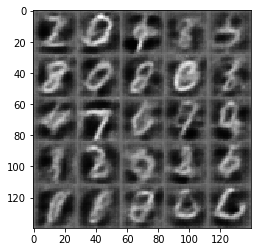

Epoch 2/2 Batch# 210... Discriminator Loss: 2.1013... Generator Loss: 0.1669
Epoch 2/2 Batch# 220... Discriminator Loss: 1.7934... Generator Loss: 0.2593
Epoch 2/2 Batch# 230... Discriminator Loss: 1.7062... Generator Loss: 0.3978
Epoch 2/2 Batch# 240... Discriminator Loss: 1.6373... Generator Loss: 0.3021
Epoch 2/2 Batch# 250... Discriminator Loss: 1.6446... Generator Loss: 0.3096
Epoch 2/2 Batch# 260... Discriminator Loss: 1.5956... Generator Loss: 0.3645
Epoch 2/2 Batch# 270... Discriminator Loss: 1.6138... Generator Loss: 0.6974
Epoch 2/2 Batch# 280... Discriminator Loss: 1.6432... Generator Loss: 0.3560
Epoch 2/2 Batch# 290... Discriminator Loss: 1.6731... Generator Loss: 0.3158
Epoch 2/2 Batch# 300... Discriminator Loss: 1.5252... Generator Loss: 0.4009


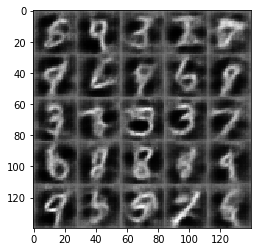

Epoch 2/2 Batch# 310... Discriminator Loss: 1.5256... Generator Loss: 0.3752
Epoch 2/2 Batch# 320... Discriminator Loss: 1.4527... Generator Loss: 0.5129
Epoch 2/2 Batch# 330... Discriminator Loss: 1.6657... Generator Loss: 0.3675
Epoch 2/2 Batch# 340... Discriminator Loss: 2.0029... Generator Loss: 0.1866
Epoch 2/2 Batch# 350... Discriminator Loss: 1.6681... Generator Loss: 0.3245
Epoch 2/2 Batch# 360... Discriminator Loss: 1.5952... Generator Loss: 0.4109
Epoch 2/2 Batch# 370... Discriminator Loss: 1.6668... Generator Loss: 0.3593
Epoch 2/2 Batch# 380... Discriminator Loss: 1.6962... Generator Loss: 0.3718
Epoch 2/2 Batch# 390... Discriminator Loss: 1.6735... Generator Loss: 0.3777
Epoch 2/2 Batch# 400... Discriminator Loss: 1.6716... Generator Loss: 0.3018


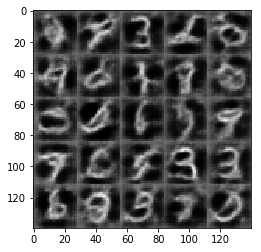

Epoch 2/2 Batch# 410... Discriminator Loss: 1.5895... Generator Loss: 0.3584
Epoch 2/2 Batch# 420... Discriminator Loss: 1.8041... Generator Loss: 0.2730
Epoch 2/2 Batch# 430... Discriminator Loss: 1.5381... Generator Loss: 0.4027
Epoch 2/2 Batch# 440... Discriminator Loss: 2.1218... Generator Loss: 0.4223
Epoch 2/2 Batch# 450... Discriminator Loss: 1.5183... Generator Loss: 0.3987
Epoch 2/2 Batch# 460... Discriminator Loss: 2.0340... Generator Loss: 0.1819


In [14]:
batch_size = 128
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 5.1417... Generator Loss: 0.0208
Epoch 1/1 Batch# 20... Discriminator Loss: 4.1366... Generator Loss: 0.0532
Epoch 1/1 Batch# 30... Discriminator Loss: 2.9688... Generator Loss: 0.1173
Epoch 1/1 Batch# 40... Discriminator Loss: 2.8026... Generator Loss: 0.1887
Epoch 1/1 Batch# 50... Discriminator Loss: 2.6947... Generator Loss: 0.1688
Epoch 1/1 Batch# 60... Discriminator Loss: 2.4060... Generator Loss: 0.2632
Epoch 1/1 Batch# 70... Discriminator Loss: 2.2012... Generator Loss: 0.3216
Epoch 1/1 Batch# 80... Discriminator Loss: 2.0041... Generator Loss: 0.4255
Epoch 1/1 Batch# 90... Discriminator Loss: 2.0373... Generator Loss: 0.3422
Epoch 1/1 Batch# 100... Discriminator Loss: 1.8596... Generator Loss: 0.4820


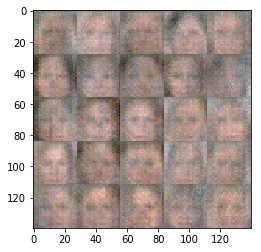

Epoch 1/1 Batch# 110... Discriminator Loss: 1.8932... Generator Loss: 0.3797
Epoch 1/1 Batch# 120... Discriminator Loss: 1.7964... Generator Loss: 0.4440
Epoch 1/1 Batch# 130... Discriminator Loss: 1.7372... Generator Loss: 0.4772
Epoch 1/1 Batch# 140... Discriminator Loss: 1.7432... Generator Loss: 0.4301
Epoch 1/1 Batch# 150... Discriminator Loss: 1.7007... Generator Loss: 0.4215
Epoch 1/1 Batch# 160... Discriminator Loss: 1.7236... Generator Loss: 0.4941
Epoch 1/1 Batch# 170... Discriminator Loss: 1.6470... Generator Loss: 0.5456
Epoch 1/1 Batch# 180... Discriminator Loss: 1.7025... Generator Loss: 0.4757
Epoch 1/1 Batch# 190... Discriminator Loss: 1.7300... Generator Loss: 0.4993
Epoch 1/1 Batch# 200... Discriminator Loss: 1.6435... Generator Loss: 0.5416


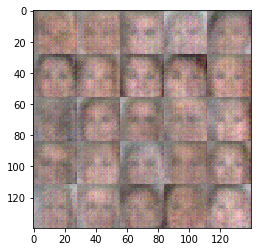

Epoch 1/1 Batch# 210... Discriminator Loss: 1.6839... Generator Loss: 0.4822
Epoch 1/1 Batch# 220... Discriminator Loss: 1.6897... Generator Loss: 0.5364
Epoch 1/1 Batch# 230... Discriminator Loss: 1.6841... Generator Loss: 0.4721
Epoch 1/1 Batch# 240... Discriminator Loss: 1.7023... Generator Loss: 0.5003
Epoch 1/1 Batch# 250... Discriminator Loss: 1.6003... Generator Loss: 0.5211
Epoch 1/1 Batch# 260... Discriminator Loss: 1.6818... Generator Loss: 0.5169
Epoch 1/1 Batch# 270... Discriminator Loss: 1.6855... Generator Loss: 0.5070
Epoch 1/1 Batch# 280... Discriminator Loss: 1.7241... Generator Loss: 0.5483
Epoch 1/1 Batch# 290... Discriminator Loss: 1.5911... Generator Loss: 0.5368
Epoch 1/1 Batch# 300... Discriminator Loss: 1.5775... Generator Loss: 0.5668


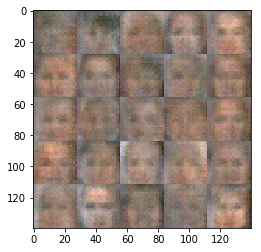

Epoch 1/1 Batch# 310... Discriminator Loss: 1.5856... Generator Loss: 0.5096
Epoch 1/1 Batch# 320... Discriminator Loss: 1.5780... Generator Loss: 0.6041
Epoch 1/1 Batch# 330... Discriminator Loss: 1.7285... Generator Loss: 0.5066
Epoch 1/1 Batch# 340... Discriminator Loss: 1.5949... Generator Loss: 0.5813
Epoch 1/1 Batch# 350... Discriminator Loss: 1.6357... Generator Loss: 0.5216
Epoch 1/1 Batch# 360... Discriminator Loss: 1.5635... Generator Loss: 0.5890
Epoch 1/1 Batch# 370... Discriminator Loss: 1.6540... Generator Loss: 0.5210
Epoch 1/1 Batch# 380... Discriminator Loss: 1.5809... Generator Loss: 0.5982
Epoch 1/1 Batch# 390... Discriminator Loss: 1.6004... Generator Loss: 0.5901
Epoch 1/1 Batch# 400... Discriminator Loss: 1.5583... Generator Loss: 0.5945


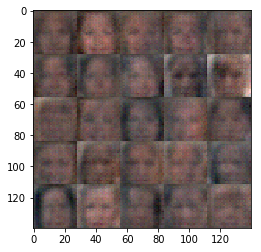

Epoch 1/1 Batch# 410... Discriminator Loss: 1.5967... Generator Loss: 0.5063
Epoch 1/1 Batch# 420... Discriminator Loss: 1.6579... Generator Loss: 0.5334
Epoch 1/1 Batch# 430... Discriminator Loss: 1.6367... Generator Loss: 0.5201
Epoch 1/1 Batch# 440... Discriminator Loss: 1.5437... Generator Loss: 0.5551
Epoch 1/1 Batch# 450... Discriminator Loss: 1.5706... Generator Loss: 0.5868
Epoch 1/1 Batch# 460... Discriminator Loss: 1.5445... Generator Loss: 0.5715
Epoch 1/1 Batch# 470... Discriminator Loss: 1.5802... Generator Loss: 0.5601
Epoch 1/1 Batch# 480... Discriminator Loss: 1.5400... Generator Loss: 0.5904
Epoch 1/1 Batch# 490... Discriminator Loss: 1.5067... Generator Loss: 0.5920
Epoch 1/1 Batch# 500... Discriminator Loss: 1.4566... Generator Loss: 0.6396


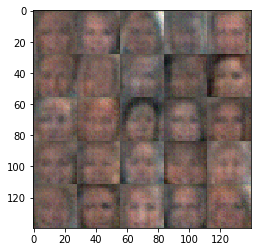

Epoch 1/1 Batch# 510... Discriminator Loss: 1.5775... Generator Loss: 0.5605
Epoch 1/1 Batch# 520... Discriminator Loss: 1.5385... Generator Loss: 0.5947
Epoch 1/1 Batch# 530... Discriminator Loss: 1.4859... Generator Loss: 0.5977
Epoch 1/1 Batch# 540... Discriminator Loss: 1.5718... Generator Loss: 0.5943
Epoch 1/1 Batch# 550... Discriminator Loss: 1.5323... Generator Loss: 0.5895
Epoch 1/1 Batch# 560... Discriminator Loss: 1.5246... Generator Loss: 0.5707
Epoch 1/1 Batch# 570... Discriminator Loss: 1.5222... Generator Loss: 0.6164
Epoch 1/1 Batch# 580... Discriminator Loss: 1.5197... Generator Loss: 0.6095
Epoch 1/1 Batch# 590... Discriminator Loss: 1.4714... Generator Loss: 0.6505
Epoch 1/1 Batch# 600... Discriminator Loss: 1.5993... Generator Loss: 0.5249


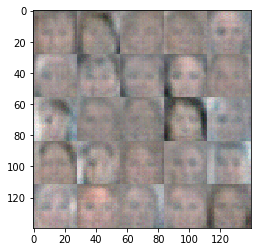

Epoch 1/1 Batch# 610... Discriminator Loss: 1.4950... Generator Loss: 0.5908
Epoch 1/1 Batch# 620... Discriminator Loss: 1.4740... Generator Loss: 0.6366
Epoch 1/1 Batch# 630... Discriminator Loss: 1.5511... Generator Loss: 0.5799
Epoch 1/1 Batch# 640... Discriminator Loss: 1.4912... Generator Loss: 0.6004
Epoch 1/1 Batch# 650... Discriminator Loss: 1.5688... Generator Loss: 0.5501
Epoch 1/1 Batch# 660... Discriminator Loss: 1.5566... Generator Loss: 0.5772
Epoch 1/1 Batch# 670... Discriminator Loss: 1.5422... Generator Loss: 0.6127
Epoch 1/1 Batch# 680... Discriminator Loss: 1.5199... Generator Loss: 0.5889
Epoch 1/1 Batch# 690... Discriminator Loss: 1.4989... Generator Loss: 0.6576
Epoch 1/1 Batch# 700... Discriminator Loss: 1.5222... Generator Loss: 0.5870


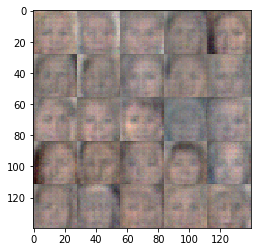

Epoch 1/1 Batch# 710... Discriminator Loss: 1.4451... Generator Loss: 0.6389
Epoch 1/1 Batch# 720... Discriminator Loss: 1.5364... Generator Loss: 0.6133
Epoch 1/1 Batch# 730... Discriminator Loss: 1.4987... Generator Loss: 0.6286
Epoch 1/1 Batch# 740... Discriminator Loss: 1.4862... Generator Loss: 0.5959
Epoch 1/1 Batch# 750... Discriminator Loss: 1.4779... Generator Loss: 0.6089
Epoch 1/1 Batch# 760... Discriminator Loss: 1.5220... Generator Loss: 0.6297
Epoch 1/1 Batch# 770... Discriminator Loss: 1.5163... Generator Loss: 0.6037
Epoch 1/1 Batch# 780... Discriminator Loss: 1.5509... Generator Loss: 0.5555
Epoch 1/1 Batch# 790... Discriminator Loss: 1.4891... Generator Loss: 0.6276
Epoch 1/1 Batch# 800... Discriminator Loss: 1.5240... Generator Loss: 0.5935


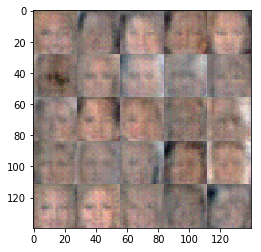

Epoch 1/1 Batch# 810... Discriminator Loss: 1.5213... Generator Loss: 0.6488
Epoch 1/1 Batch# 820... Discriminator Loss: 1.4959... Generator Loss: 0.6044
Epoch 1/1 Batch# 830... Discriminator Loss: 1.5363... Generator Loss: 0.5894
Epoch 1/1 Batch# 840... Discriminator Loss: 1.6120... Generator Loss: 0.5595
Epoch 1/1 Batch# 850... Discriminator Loss: 1.5063... Generator Loss: 0.5659
Epoch 1/1 Batch# 860... Discriminator Loss: 1.5826... Generator Loss: 0.5906
Epoch 1/1 Batch# 870... Discriminator Loss: 1.5431... Generator Loss: 0.5492
Epoch 1/1 Batch# 880... Discriminator Loss: 1.5066... Generator Loss: 0.6136
Epoch 1/1 Batch# 890... Discriminator Loss: 1.5223... Generator Loss: 0.6051
Epoch 1/1 Batch# 900... Discriminator Loss: 1.4887... Generator Loss: 0.6005


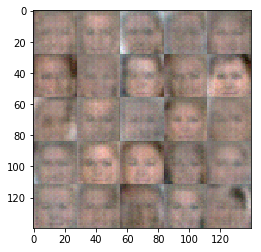

Epoch 1/1 Batch# 910... Discriminator Loss: 1.5169... Generator Loss: 0.6459
Epoch 1/1 Batch# 920... Discriminator Loss: 1.4785... Generator Loss: 0.6520
Epoch 1/1 Batch# 930... Discriminator Loss: 1.5171... Generator Loss: 0.5720
Epoch 1/1 Batch# 940... Discriminator Loss: 1.4789... Generator Loss: 0.6003
Epoch 1/1 Batch# 950... Discriminator Loss: 1.5273... Generator Loss: 0.6135
Epoch 1/1 Batch# 960... Discriminator Loss: 1.5123... Generator Loss: 0.6122
Epoch 1/1 Batch# 970... Discriminator Loss: 1.5208... Generator Loss: 0.6337
Epoch 1/1 Batch# 980... Discriminator Loss: 1.4987... Generator Loss: 0.6722
Epoch 1/1 Batch# 990... Discriminator Loss: 1.4738... Generator Loss: 0.6359
Epoch 1/1 Batch# 1000... Discriminator Loss: 1.5471... Generator Loss: 0.5890


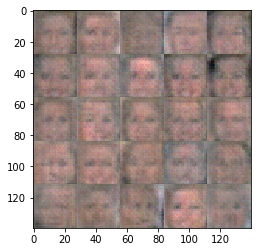

Epoch 1/1 Batch# 1010... Discriminator Loss: 1.5112... Generator Loss: 0.6285
Epoch 1/1 Batch# 1020... Discriminator Loss: 1.5474... Generator Loss: 0.6143
Epoch 1/1 Batch# 1030... Discriminator Loss: 1.5373... Generator Loss: 0.5965
Epoch 1/1 Batch# 1040... Discriminator Loss: 1.4994... Generator Loss: 0.5818
Epoch 1/1 Batch# 1050... Discriminator Loss: 1.5143... Generator Loss: 0.5863
Epoch 1/1 Batch# 1060... Discriminator Loss: 1.5810... Generator Loss: 0.5766
Epoch 1/1 Batch# 1070... Discriminator Loss: 1.5261... Generator Loss: 0.6114
Epoch 1/1 Batch# 1080... Discriminator Loss: 1.5666... Generator Loss: 0.5636
Epoch 1/1 Batch# 1090... Discriminator Loss: 1.4929... Generator Loss: 0.6631
Epoch 1/1 Batch# 1100... Discriminator Loss: 1.5176... Generator Loss: 0.6301


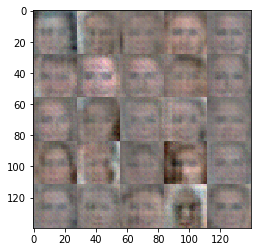

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.5264... Generator Loss: 0.5835
Epoch 1/1 Batch# 1120... Discriminator Loss: 1.5522... Generator Loss: 0.5876
Epoch 1/1 Batch# 1130... Discriminator Loss: 1.5577... Generator Loss: 0.6109
Epoch 1/1 Batch# 1140... Discriminator Loss: 1.5623... Generator Loss: 0.5728
Epoch 1/1 Batch# 1150... Discriminator Loss: 1.5534... Generator Loss: 0.5925
Epoch 1/1 Batch# 1160... Discriminator Loss: 1.5248... Generator Loss: 0.5734
Epoch 1/1 Batch# 1170... Discriminator Loss: 1.5238... Generator Loss: 0.6049
Epoch 1/1 Batch# 1180... Discriminator Loss: 1.5272... Generator Loss: 0.6131
Epoch 1/1 Batch# 1190... Discriminator Loss: 1.4886... Generator Loss: 0.5606
Epoch 1/1 Batch# 1200... Discriminator Loss: 1.5169... Generator Loss: 0.6282


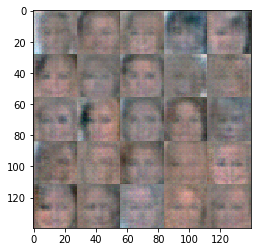

Epoch 1/1 Batch# 1210... Discriminator Loss: 1.4852... Generator Loss: 0.6135
Epoch 1/1 Batch# 1220... Discriminator Loss: 1.4682... Generator Loss: 0.6654
Epoch 1/1 Batch# 1230... Discriminator Loss: 1.4911... Generator Loss: 0.5859
Epoch 1/1 Batch# 1240... Discriminator Loss: 1.5210... Generator Loss: 0.5994
Epoch 1/1 Batch# 1250... Discriminator Loss: 1.4829... Generator Loss: 0.6002
Epoch 1/1 Batch# 1260... Discriminator Loss: 1.4814... Generator Loss: 0.6009
Epoch 1/1 Batch# 1270... Discriminator Loss: 1.4580... Generator Loss: 0.6154
Epoch 1/1 Batch# 1280... Discriminator Loss: 1.4885... Generator Loss: 0.6844
Epoch 1/1 Batch# 1290... Discriminator Loss: 1.4931... Generator Loss: 0.5781
Epoch 1/1 Batch# 1300... Discriminator Loss: 1.4418... Generator Loss: 0.6358


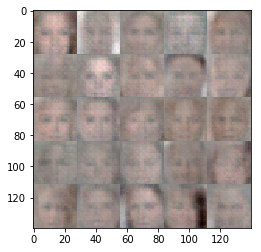

Epoch 1/1 Batch# 1310... Discriminator Loss: 1.4788... Generator Loss: 0.6443
Epoch 1/1 Batch# 1320... Discriminator Loss: 1.4404... Generator Loss: 0.6476
Epoch 1/1 Batch# 1330... Discriminator Loss: 1.4712... Generator Loss: 0.6088
Epoch 1/1 Batch# 1340... Discriminator Loss: 1.4526... Generator Loss: 0.6248
Epoch 1/1 Batch# 1350... Discriminator Loss: 1.4534... Generator Loss: 0.6084
Epoch 1/1 Batch# 1360... Discriminator Loss: 1.4540... Generator Loss: 0.6158
Epoch 1/1 Batch# 1370... Discriminator Loss: 1.4715... Generator Loss: 0.5993
Epoch 1/1 Batch# 1380... Discriminator Loss: 1.5064... Generator Loss: 0.6342
Epoch 1/1 Batch# 1390... Discriminator Loss: 1.4761... Generator Loss: 0.6444
Epoch 1/1 Batch# 1400... Discriminator Loss: 1.4686... Generator Loss: 0.6476


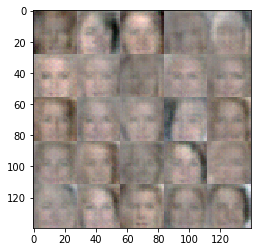

Epoch 1/1 Batch# 1410... Discriminator Loss: 1.4530... Generator Loss: 0.6288
Epoch 1/1 Batch# 1420... Discriminator Loss: 1.4515... Generator Loss: 0.6125
Epoch 1/1 Batch# 1430... Discriminator Loss: 1.4628... Generator Loss: 0.6303
Epoch 1/1 Batch# 1440... Discriminator Loss: 1.4678... Generator Loss: 0.6701
Epoch 1/1 Batch# 1450... Discriminator Loss: 1.5376... Generator Loss: 0.6258
Epoch 1/1 Batch# 1460... Discriminator Loss: 1.5468... Generator Loss: 0.6004
Epoch 1/1 Batch# 1470... Discriminator Loss: 1.4770... Generator Loss: 0.6440
Epoch 1/1 Batch# 1480... Discriminator Loss: 1.5542... Generator Loss: 0.6439
Epoch 1/1 Batch# 1490... Discriminator Loss: 1.4358... Generator Loss: 0.6410
Epoch 1/1 Batch# 1500... Discriminator Loss: 1.4861... Generator Loss: 0.6054


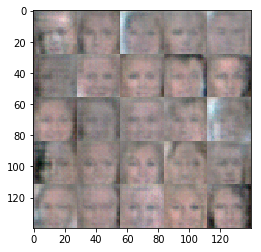

Epoch 1/1 Batch# 1510... Discriminator Loss: 1.5097... Generator Loss: 0.5974
Epoch 1/1 Batch# 1520... Discriminator Loss: 1.4931... Generator Loss: 0.6002
Epoch 1/1 Batch# 1530... Discriminator Loss: 1.4911... Generator Loss: 0.6041
Epoch 1/1 Batch# 1540... Discriminator Loss: 1.4550... Generator Loss: 0.6673
Epoch 1/1 Batch# 1550... Discriminator Loss: 1.4889... Generator Loss: 0.6083
Epoch 1/1 Batch# 1560... Discriminator Loss: 1.4790... Generator Loss: 0.6244
Epoch 1/1 Batch# 1570... Discriminator Loss: 1.4669... Generator Loss: 0.6427
Epoch 1/1 Batch# 1580... Discriminator Loss: 1.4878... Generator Loss: 0.5926


In [15]:
batch_size = 128
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.